In [ ]:
import os, cv2, json
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns


from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications import EfficientNetB6
from tensorflow.keras.applications import InceptionV3

from tensorflow.keras.applications import ResNet50

from tensorflow.keras.optimizers import Adam

from PIL import Image

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Input, BatchNormalization, GlobalAveragePooling2D

from tensorflow.keras.models import load_model

In [ ]:
train = pd.read_csv("/content/train.csv")

In [ ]:
from sklearn.model_selection import train_test_split
df_train, df_validate, y_train, y_test = train_test_split(train, train.label,train_size=0.8,random_state=42,stratify=train.label)

In [ ]:
df_train = df_train.reset_index(drop=True)
df_validate = df_validate.reset_index(drop=True)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Now you can access files from Google Drive like this:
dataset_path = '/content/drive/My Drive/Tomato_images/Tomato_images'  # Update with your folder's path


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Main parameters
BATCH_SIZE = 16
STEPS_PER_EPOCH = 500
EPOCHS =10 #
IMG_WIDTH= 150
IMG_HEIGHT= 150
train_dir = '/content/drive/My Drive/Tomato_images/Tomato_images'

In [ ]:
df_train.label = df_train.label.astype('str')
df_validate.label = df_validate.label.astype('str')

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255,
                               shear_range = 0.2,
                               zoom_range = 0.2,
                               rotation_range = 180,
                               vertical_flip = True,
                               horizontal_flip = True)
# our train_datagen generator will use the following transformations on the images
validation_datagen = ImageDataGenerator(rescale=1./255)

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create the ImageDataGenerator with rescaling and resizing
train_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(df_train,
                                                    train_dir,
                                                    target_size=(150,150),
                                                    batch_size=16,
                                                    x_col='img',
                                                    y_col='label',
                                                    class_mode = 'categorical')

# generator = ImageDataGenerator(*args).flow_from_dataframe(dataframe, directory, target_size,
# batch_size, x_col, y_col, class_mode)
# your dataframe shoudl be in the format such that x_col = features, y_col = class/label
# binary class mode since output is either 0(dog) or 1(cat)

validation_generator = validation_datagen.flow_from_dataframe(df_validate,
                                                   train_dir,
                                                    target_size=(150,150),
                                                    x_col='img',
                                                    y_col='label',
                                                    class_mode='categorical',
                                                  batch_size=16)

Found 3039 validated image filenames belonging to 10 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 11489 invalid image filename(s) in x_col="img". These filename(s) will be ignored.
  warnings.warn(


Found 811 validated image filenames belonging to 10 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 2821 invalid image filename(s) in x_col="img". These filename(s) will be ignored.
  warnings.warn(


In [ ]:
# Load Pretrained ResNet50 Model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
base_model.trainable = False  # Freeze base model layers

# Add Custom Layers on Top
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(len(train_generator.class_indices), activation='softmax')  # Output Layer
])

# Compile the Model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Define Callbacks
model_checkpoint = ModelCheckpoint('/content/drive/My Drive/leaf_disease_ResNet50.h5',
                                   save_best_only=True, monitor='val_loss', mode='min', verbose=1)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=1)

# Train the Model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,
    callbacks=[model_checkpoint, early_stopping, reduce_lr]
)

# Save Model for Future Inference
model.save("/content/drive/My Drive/leaf_disease_final_ResNet50.h5")


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2604 - loss: 2.2049
Epoch 1: val_loss improved from inf to 2.06533, saving model to /content/drive/My Drive/leaf_disease_ResNet50.h5


190/190 ━━━━━━━━━━━━━━━━━━━━ 356s 2s/step - accuracy: 0.2605 - loss: 2.2047 - val_accuracy: 0.3083 - val_loss: 2.0653 - learning_rate: 1.0000e-04
Epoch 2/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3129 - loss: 2.1052
Epoch 2: val_loss improved from 2.06533 to 2.04550, saving model to /content/drive/My Drive/leaf_disease_ResNet50.h5


190/190 ━━━━━━━━━━━━━━━━━━━━ 342s 2s/step - accuracy: 0.3129 - loss: 2.1052 - val_accuracy: 0.3083 - val_loss: 2.0455 - learning_rate: 1.0000e-04
Epoch 3/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3078 - loss: 2.0669
Epoch 3: val_loss improved from 2.04550 to 2.01850, saving model to /content/drive/My Drive/leaf_disease_ResNet50.h5


190/190 ━━━━━━━━━━━━━━━━━━━━ 343s 2s/step - accuracy: 0.3077 - loss: 2.0670 - val_accuracy: 0.3083 - val_loss: 2.0185 - learning_rate: 1.0000e-04
Epoch 4/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3061 - loss: 2.0562
Epoch 4: val_loss improved from 2.01850 to 1.97419, saving model to /content/drive/My Drive/leaf_disease_ResNet50.h5


190/190 ━━━━━━━━━━━━━━━━━━━━ 355s 2s/step - accuracy: 0.3061 - loss: 2.0562 - val_accuracy: 0.3120 - val_loss: 1.9742 - learning_rate: 1.0000e-04
Epoch 5/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3118 - loss: 2.0095
Epoch 5: val_loss improved from 1.97419 to 1.95235, saving model to /content/drive/My Drive/leaf_disease_ResNet50.h5


190/190 ━━━━━━━━━━━━━━━━━━━━ 338s 2s/step - accuracy: 0.3118 - loss: 2.0095 - val_accuracy: 0.3292 - val_loss: 1.9523 - learning_rate: 1.0000e-04
Epoch 6/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3326 - loss: 1.9687
Epoch 6: val_loss improved from 1.95235 to 1.93272, saving model to /content/drive/My Drive/leaf_disease_ResNet50.h5


190/190 ━━━━━━━━━━━━━━━━━━━━ 352s 2s/step - accuracy: 0.3326 - loss: 1.9687 - val_accuracy: 0.3243 - val_loss: 1.9327 - learning_rate: 1.0000e-04
Epoch 7/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3336 - loss: 1.9431
Epoch 7: val_loss improved from 1.93272 to 1.90850, saving model to /content/drive/My Drive/leaf_disease_ResNet50.h5


190/190 ━━━━━━━━━━━━━━━━━━━━ 339s 2s/step - accuracy: 0.3336 - loss: 1.9431 - val_accuracy: 0.3243 - val_loss: 1.9085 - learning_rate: 1.0000e-04
Epoch 8/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3191 - loss: 1.9676
Epoch 8: val_loss improved from 1.90850 to 1.90418, saving model to /content/drive/My Drive/leaf_disease_ResNet50.h5


190/190 ━━━━━━━━━━━━━━━━━━━━ 353s 2s/step - accuracy: 0.3192 - loss: 1.9675 - val_accuracy: 0.3317 - val_loss: 1.9042 - learning_rate: 1.0000e-04
Epoch 9/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3370 - loss: 1.9345
Epoch 9: val_loss improved from 1.90418 to 1.88966, saving model to /content/drive/My Drive/leaf_disease_ResNet50.h5


190/190 ━━━━━━━━━━━━━━━━━━━━ 337s 2s/step - accuracy: 0.3371 - loss: 1.9345 - val_accuracy: 0.3403 - val_loss: 1.8897 - learning_rate: 1.0000e-04
Epoch 10/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3488 - loss: 1.9145
Epoch 10: val_loss improved from 1.88966 to 1.87946, saving model to /content/drive/My Drive/leaf_disease_ResNet50.h5


190/190 ━━━━━━━━━━━━━━━━━━━━ 345s 2s/step - accuracy: 0.3488 - loss: 1.9144 - val_accuracy: 0.3268 - val_loss: 1.8795 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 10.


In [ ]:
# Load ResNet50 WITHOUT fully connected layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Freeze all convolutional layers
base_model.trainable = False

# Find the last convolutional layer in ResNet50
last_conv_layer_name = "conv5_block3_out"  # This should exist in ResNet50

# Create the model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.3)(x)
out = Dense(len(df_train.label.unique()), activation='softmax')(x)  # Adjust for your classes

model = models.Model(inputs=base_model.input, outputs=out)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

print("✅ ResNet50 Model Built Successfully!")


✅ ResNet50 Model Built Successfully!


Grad-CAM (Gradient-weighted Class Activation Mapping) visualization shows how your ResNet50 model identifies disease-related regions on the tomato leaf.

What is Grad-CAM Doing?

It identifies which parts of the image influenced the model’s prediction the most.

It does this by computing the gradients of the predicted class score w.r.t. the feature maps of a specific CNN layer.

The resulting heatmap highlights highly influential regions (in red/yellow) and less important regions (in blue/green).

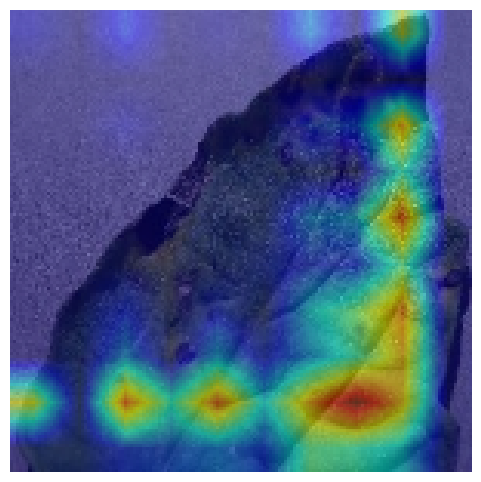

In [ ]:
def grad_cam(sample_image, model, layer_name="conv4_block6_out"):
    img = cv2.imread("/content/drive/MyDrive/Tomato_images/Tomato_images/0012b9d2-2130-4a06-a834-b1f3af34f57e___RS_Erly.B 8389.JPG")

    if img is None:
        print(f" Error: Unable to load image at {image_path}")
        return

    img = cv2.resize(img, (150, 150))
    img_array = np.expand_dims(img, axis=0).astype("float32") / 255.0

    # Check if layer exists
    if layer_name not in [layer.name for layer in model.layers]:
        print(f"Error: Layer '{layer_name}' not found in model.")
        return

    # Ensure proper input structure
    grad_model = tf.keras.models.Model(inputs=model.input, outputs=[model.get_layer(layer_name).output, model.output])

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array, training=False)  # 🚀 Fixes input warning!
        class_idx = np.argmax(predictions)
        loss = predictions[:, class_idx]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    heatmap = np.maximum(heatmap[0], 0)
    heatmap /= np.max(heatmap)

    heatmap = cv2.resize(heatmap, (150, 150))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed = cv2.addWeighted(img, 0.5, heatmap, 0.5, 0)


    plt.figure(figsize=(6, 6))
    plt.imshow(cv2.cvtColor(superimposed, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

# Test Again
sample_image = "/content/drive/MyDrive/Tomato_images/Tomato_images/0012b9d2-2130-4a06-a834-b1f3af34f57e___RS_Erly.B 8389.JPG"
grad_cam(sample_image, model)


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_358']]
Received: inputs=Tensor(shape=(1, 150, 150, 3))
  warnings.warn(msg)


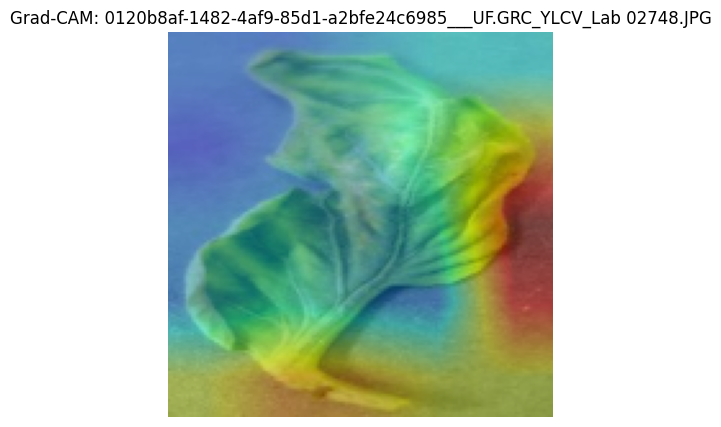

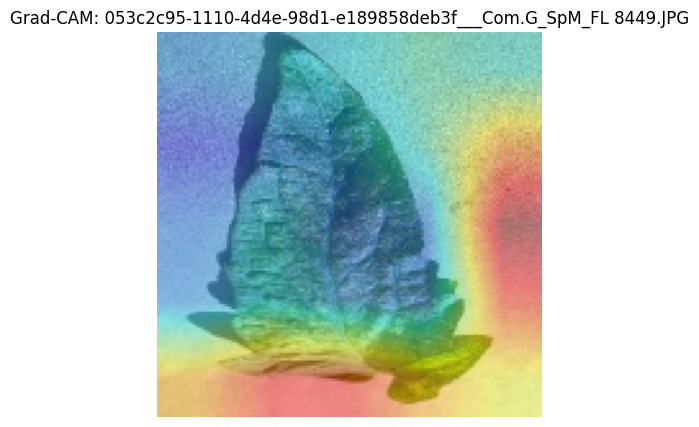

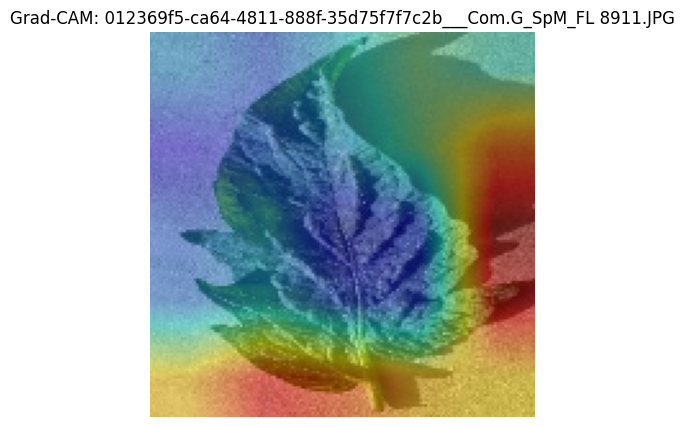

Saved: /content/drive/MyDrive/Tomato_images/GradCAM_results/gradcam_1070e740-6ac0-4e66-b450-ae7ced095091___Com.G_TgS_FL 0757.JPG
Saved: /content/drive/MyDrive/Tomato_images/GradCAM_results/gradcam_103210e0-a963-4d63-a23f-0e1bbe7f2f58___UF.GRC_YLCV_Lab 01639.JPG
Saved: /content/drive/MyDrive/Tomato_images/GradCAM_results/gradcam_0f12e22b-49a9-4d9a-84bc-76bb86ed2a14___RS_Erly.B 9572.JPG
Saved: /content/drive/MyDrive/Tomato_images/GradCAM_results/gradcam_02dfe58f-0ad1-4bf6-838a-e145978b1eed___GCREC_Bact.Sp 5841.JPG
Saved: /content/drive/MyDrive/Tomato_images/GradCAM_results/gradcam_109e896c-55e4-4e8e-a8eb-5d80e71e627f___UF.GRC_YLCV_Lab 09519.JPG
Saved: /content/drive/MyDrive/Tomato_images/GradCAM_results/gradcam_111a63c7-6445-47a4-a0d6-9157fd82b804___UF.GRC_BS_Lab Leaf 0565.JPG
Saved: /content/drive/MyDrive/Tomato_images/GradCAM_results/gradcam_2669130b-d44c-4ed6-bd47-2e0deb8e5b34___UF.GRC_YLCV_Lab 03299.JPG
Saved: /content/drive/MyDrive/Tomato_images/GradCAM_results/gradcam_22b8de0e-636d

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf

def grad_cam(image_path, model, layer_name='conv5_block3_out'):
    img = cv2.imread(image_path)

    if img is None:
        print(f"Error: Unable to load {image_path}")
        return None

    img = cv2.resize(img, (150, 150))
    img_array = np.expand_dims(img, axis=0) / 255.0

    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(layer_name).output, model.output])

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        class_idx = np.argmax(predictions)
        loss = predictions[:, class_idx]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    heatmap = np.maximum(heatmap[0], 0)
    heatmap /= np.max(heatmap)

    heatmap = cv2.resize(heatmap, (150, 150))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)

    return superimposed

# 📂 **Folder Paths**
image_folder = "/content/drive/MyDrive/Tomato_images/Tomato_images"
output_folder = "/content/drive/MyDrive/Tomato_images/GradCAM_results"

os.makedirs(output_folder, exist_ok=True)

# 📸 **Get all image names**
image_files = os.listdir(image_folder)

# 🎯 **Randomly select 3 images to display**
random.shuffle(image_files)
show_images = image_files[:3]  # First 3 images for display
save_images = image_files[3:]  # Rest for saving

# 🔥 **Process & Show First 3 Images**
for img_name in show_images:
    img_path = os.path.join(image_folder, img_name)
    heatmap_img = grad_cam(img_path, model)

    if heatmap_img is not None:
        plt.figure(figsize=(5, 5))
        plt.imshow(cv2.cvtColor(heatmap_img, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title(f"Grad-CAM: {img_name}")
        plt.show()

# 💾 **Process & Save Remaining Images**
for img_name in save_images:
    img_path = os.path.join(image_folder, img_name)
    output_path = os.path.join(output_folder, f"gradcam_{img_name}")

    heatmap_img = grad_cam(img_path, model)

    if heatmap_img is not None:
        cv2.imwrite(output_path, heatmap_img)  # Save Grad-CAM image
        print(f"Saved: {output_path}")


In [ ]:
import tensorflow as tf

# Define the correct path to the model in Google Drive
model_path = "/content/drive/MyDrive/leaf_disease_final_ResNet50.h5"  # Use the appropriate file name

# Load the trained model
model = tf.keras.models.load_model(model_path)

# Convert the model to TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model
with open("model.tflite", "wb") as f:
    f.write(tflite_model)

print("✅ Model converted to TensorFlow Lite and saved as model.tflite")


In [ ]:
import tensorflow as tf
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path="model.tflite")
interpreter.allocate_tensors()

# Get input and output tensor details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Load an image for testing (modify path as needed)
image_path = "/content/images.jpeg"  # Change this to your image
image = Image.open(image_path).resize((150, 150))  # Resize as per model input
image_array = np.array(image, dtype=np.float32) / 255.0  # Normalize
image_array = np.expand_dims(image_array, axis=0)  # Add batch dimension

# Perform inference
interpreter.set_tensor(input_details[0]['index'], image_array)
interpreter.invoke()
output = interpreter.get_tensor(output_details[0]['index'])

# Get predicted class
predicted_class = np.argmax(output)

# Display the image with prediction
plt.figure(figsize=(6, 6))
plt.imshow(image)
plt.axis('off')
plt.title(f"Predicted Class: {predicted_class}", fontsize=14, color="red")
plt.show()
